In [87]:
# Qutip
from qutip import *
from tqdm import tqdm

#from collections import namedtuple

# Scipy
import scipy as sp
import scipy.integrate as integrate
import scipy.special as special
import scipy.sparse as spr
from scipy.sparse.linalg import eigs
from scipy.integrate import quad, dblquad

# Matplotlib
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# For latex fonts in the plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
#plt.style.use('ggplot')

# For indexing plots smartly and automatically
import string
alphabet = list(string.ascii_lowercase)

# Math
import csv
import numpy as np
import math as mt
from sympy import Matrix

# To animate the Bloch sphere
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Bonus
import itertools as itr
from tqdm import tqdm_notebook
import time
import imageio
import time, sys
from IPython.display import clear_output
from scipy.sparse.linalg import eigs
import pickle

# 1. 4LS Hilbert space and linear polarizations

In [131]:
# 4LS basis
[spinDw, spinUp, trionDw, trionUp] = [basis(4,i) for i in range(4)]

# Circular polarization operators
sigmaR = spinUp*trionUp.dag()
sigmaL = spinDw*trionDw.dag()

#Linear polarization operators
sigmaH = (sigmaR + sigmaL)/np.sqrt(2)
sigmaV = np.exp(1j*np.pi/2)*(sigmaR - sigmaL)/np.sqrt(2)
sigmaA = np.exp(1j*np.pi/4)*(sigmaR - 1j*sigmaL)/np.sqrt(2)
sigmaD = np.exp(-1j*np.pi/4)*(sigmaR + 1j*sigmaL)/np.sqrt(2)

#qBhat calculator

qBhat = spinUp*spinDw.dag() 

In [132]:
qBhat

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

# 2. Physical system definition

In [133]:
#Initial state
psi0 = (spinDw + spinUp).unit()
psi0

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.70710678]
 [0.70710678]
 [0.        ]
 [0.        ]]

In [134]:
# Decreasing pulse
def H1_coeff(t, args):
    return np.sqrt(nH*Gamma)*np.exp(-(Gamma/2)*t)

In [135]:
# Jump operators
gamma = 1
jump_ops = [np.sqrt(gamma)*sigmaR, np.sqrt(gamma)*sigmaL]

In [136]:
detuning = 0

H0 = detuning*(sigmaR.dag()*sigmaR + sigmaL.dag()*sigmaL)
H1 = 1j*np.sqrt(gamma)*(sigmaH.dag() - sigmaH)

H = [H0,[H1, H1_coeff]]

In [137]:
%%time
gamma = 1
nH = 100
Gamma = 10

tf = 50.*Gamma
delta_t = 0.1
tlist = np.arange(0, tf+delta_t, delta_t)

output = mesolve(H, psi0, tlist, jump_ops, [qBhat, sigmaR.dag()*sigmaR, sigmaL.dag()*sigmaL])


CPU times: user 198 ms, sys: 5.74 ms, total: 203 ms
Wall time: 202 ms


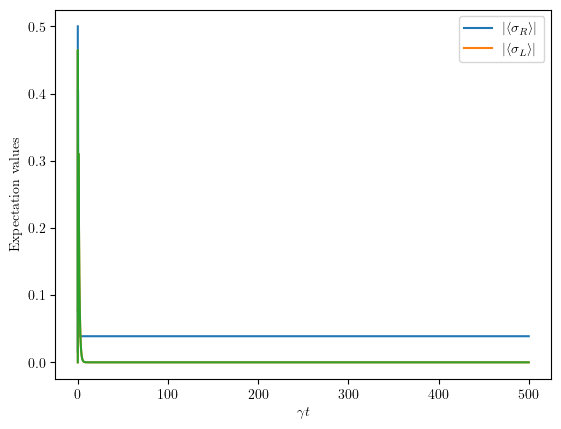

In [138]:
fig, ax = plt.subplots()

ax.plot(tlist, np.abs(output.expect[0])) 

ax.plot(tlist, np.abs(output.expect[1])) 

ax.plot(tlist, np.abs(output.expect[2])) 

ax.set_xlabel(r'$\gamma t$') 

ax.set_ylabel('Expectation values') 

ax.legend((r"$\vert\langle\sigma_R\rangle\vert$", r"$\vert\langle\sigma_L\rangle\vert$"))  

plt.show() 

In [96]:
#rho_ss = steadystate(H, jump_ops)

In [139]:
nH_list = np.arange(10**(-1),10**0+ 10**(-1), 10**(-1))
Gamma_list = np.arange(10**(-2),10**1+ 10**(-1), 10**(-1))

In [ ]:
%%time
qBhat_cs = []
onlyqBhat_cs = []

gamma = 1
for nH in tqdm(nH_list):
    for Gamma in tqdm(Gamma_list):
        
        tf = 10000.*Gamma
        delta_t = 10
        tlist = np.arange(0, tf+delta_t, delta_t)
        
        output = mesolve(H, psi0, tlist, jump_ops, [qBhat, sigmaR.dag()*sigmaR, sigmaL.dag()*sigmaL])
        
        qBhat_cs.append([nH, Gamma, output.expect[0][-1]])
        
        

100%|█████████████████████████████████████████| 101/101 [30:48<00:00, 18.30s/it]


 63%|█████████████████████████▎              | 64/101 [2:23:52<27:08, 44.00s/it]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Extract x, y, and z values from the list
data = qBhat_cs
x = np.array([point[0] for point in data])
y = np.array([point[1] for point in data])
z = np.array([np.abs(point[2]) for point in data])

# Create a meshgrid of x and y values
x_grid, y_grid = np.meshgrid(np.unique(x), np.unique(y))

# Interpolate z values on the meshgrid
z_grid = griddata((x, y), z, (x_grid, y_grid), method='linear')

# Create the contour plot
plt.contourf(x_grid, y_grid, z_grid)
plt.colorbar()  # Add a colorbar
#plt.xlabel('x')
plt.xlabel(r'$\bar{n}$')
plt.title('Contour Plot')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Display the plot
plt.show()

# 3. Steady state qBhat